In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn_extra.cluster import KMedoids

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *
from codes.batch_ucb import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
Path = '../../data/firstRound_Microplate_normTrue_formatSeq_logTrue.csv'

known_df = pd.read_csv(Path)
known_df.head()

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,1.616261,1.814182,1.760954,2.186207,2.028863,1.831982,1.881293,0.225819
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,1.166174,1.337018,1.417248,1.493800,1.713526,1.644568,1.425553,0.201725
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,0.604551,0.751384,0.851987,0.514929,0.577299,0.795227,0.660030,0.137994
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,1.221264,1.466278,1.270212,1.341040,1.395030,1.175433,1.338765,0.097386
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,1.160566,1.579025,1.171829,1.590670,1.411255,1.756862,1.382669,0.210012


In [3]:
run_new_experiment = False

if run_new_experiment:
    top_n = Top_n_ucb(known_df, kernel_name='WD_Kernel_Shift', l=6, s=1,
                     embedding='label', alpha=1, rec_size=None, beta=1)

    top_n_rec_df = top_n.run_experiment()

    top_n_rec_df

    with pd.ExcelWriter('top_n_rec.xlsx', engine="openpyxl", mode='a') as writer:  
        top_n_rec_df.to_excel(writer, sheet_name='train_samples_alpha1')

## Read prediction data; Plot ucb scores

Take two prediction list from different pipelines, take the union set of top n ucb scores, and scatter plot the ucb scores for both pipeline predictions. 
x and y axis represents the predicted ucb scores from each pipeline, the same point represents the same sequence. 

In [21]:
ucb_train_samples = pd.read_excel('all_ucb_pred.xlsx', sheet_name='train_samples_alpha0.1')
ucb_train_seqs = pd.read_excel('all_ucb_pred.xlsx', sheet_name='train_seq_alpha0.1')
ucb_train_samples_alpha1 = pd.read_excel('all_ucb_pred.xlsx', sheet_name='train_samples_alpha1')

In [19]:
def scatterplot_union_ucb_scores(df1, df2, df1_name, df2_name, rec_size = 90):
    """For two rec df from different pipelines,
    take the union set and scatter plot ucb scores.
    
    Input dataframe has at least two columns: index, ucb
    """
    union_rec_index = list(set(df1[:rec_size]['index']).union(set(df2[:rec_size]['index'])))
    print('union set size: ', len(union_rec_index))
    new_df1 = df1.loc[df1['index'].isin(union_rec_index)][['index', 'ucb']]
    new_df2 = df2.loc[df2['index'].isin(union_rec_index)][['index', 'ucb']]
    
    merge_df = new_df1.merge(new_df2, on = 'index')
    merge_df = merge_df.rename(columns = {'ucb_x': str(df1_name), 'ucb_y': str(df2_name)})
    sns.scatterplot(x = str(df1_name), y = str(df2_name), data = merge_df)

### Train samples vs Train seqs

with same parameters (kernel_name='WD_Kernel_Shift', l=6, s=1, embedding='label', alpha=1, rec_size=None, beta=1)

We can see the top scores are similar for both approach, while the lower scores are differs in a smaller scale (~ 0.5). This means training with samples (multiples scores) and training with sequences (average score) give similar recommendations. 

union set size:  126


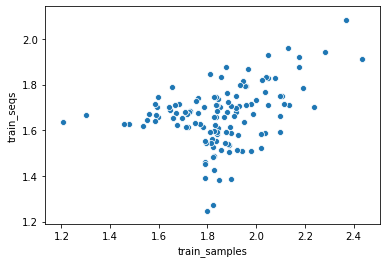

In [20]:
scatterplot_union_ucb_scores(ucb_train_samples, ucb_train_seqs, 'train_samples', 'train_seqs')

### Train samples with alpha 0.1 vs alpha 1

with same other parameters (kernel_name='WD_Kernel_Shift', l=6, s=1, embedding='label', rec_size=None, beta=1)

we can see changing the alpha value changes the predicted ucb significantly. 

union set size:  176


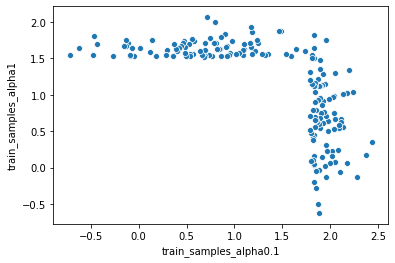

In [22]:
scatterplot_union_ucb_scores(ucb_train_samples, ucb_train_samples_alpha1, 'train_samples_alpha0.1', 'train_samples_alpha1')